### Packages

In [1]:
# Import all necessary packages
# Package for reading las/laz file
import numpy as np                                             # For all calculation and data array/matrices manipulation
import pdal                                                    # For reading and writing las/laz file

# Packages for rotation
from numba import njit, guvectorize, float64                   # For speeding up the time of the code running

# Packages for converting lidar point cloud las/laz file into DEM raster netcdf file
import os                                                      # For manipulating the directory path (create/change/move folders) and to execute commands
import pathlib                                                 # For manipulating the directory path
import shapely.geometry                                        # For creating a polygon object
import geopandas                                               # For creating a series to store the shapely geometry object
import shutil                                                  # For copying file/folder
import xarray                                                  # For creating and manipulating an array of raster
import rioxarray                                               # For manipulating spatial data under xarray array format (open and write .nc/.tiff files and set crs)
import json                                                    # For creating json text data format
import pdal                                                    # For handling lidar point cloud data
from geofabrics import processor                               # For executing the command of converting lidar point cloud into a DEM raster

# Packages for unrotating and untranslating
from osgeo import gdal                                         # For manipulating rasters (calculating centers)
import rasterio.features                                       # For vectorising features in array
from shapely.geometry import shape                             # For manipulating spatial information (geometry) under GeoJSON format
import geopandas as gpd                                        # For manupulating shape files

# Package for manipulating spatial data
import rasterio                                                # For reading and manipulating spatial data

# Package for running software from outside of Python (commandline or PowerShell)
import subprocess                                              # For mainly running BG_Flood model

# Package for timing steps
import time                                                    # For timing steps

import rioxarray as rxr
import xarray as xr

import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# Change path
# Ref: https://stackoverflow.com/questions/15514593/importerror-no-module-named-when-trying-to-run-python-script/15622021#15622021
import sys
sys.path.append(r'S:\\Grid_Orientation_wse_004_changecalculation_forimageonly_bathy\\LISFLOOD_FP\\Modelling')

### Functions

In [3]:
# Create a function to read las/laz file
def read_las_file(filename):
    ''' 
    Definition:
                This function is to read the las/las file into arrays
    References: 
                https://pythonhosted.org/laspy/file.html
                https://pythonhosted.org/laspy/tut_part_1.html
    Arguments:
                filename (string):
                            Name of las/laz file
    Returns:
                points_func (array):
                            An array includes all information about the points
                coordinates_func (array):
                            An array includes x, y, z coordinates values of points as rows
    '''
    # Set up horizontal and vertical crs
    h_crs = 2193
    v_crs = 7839

    
    # Writing las/las file into arrays
    pdal_pipeline_instructions = [{"type":"readers.las", "filename": fr"{filename}"},
                                  {"type":"filters.reprojection","in_srs":f"EPSG:{h_crs}+{v_crs}",
                                   "out_srs":f"EPSG:{h_crs}+{v_crs}"}]

    pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions))
    pdal_pipeline.execute()

    # Calling out arrays
    points_func = pdal_pipeline.arrays # note is shape [1,nx,ny]
    
    # Assign x, y , z
    x_func = points_func[0]["X"]
    y_func = points_func[0]["Y"]
    z_func = points_func[0]["Z"]
    
    # Writing x, y, z into arrays with each row as (x, y, z) (centimeters as unit)
    coordinates_func = np.vstack((x_func, y_func, z_func)).transpose().astype('float64')
    
    return points_func, coordinates_func

In [4]:
def write_laz(coordinates, output):
    ''' 
    Definition:
                This function is to write out laz file of point cloud data
    References: 
                None
    Arguments:
                coordinates (array):
                            3d arrays of x, y, z coordinates of point cloud data
                output:
                            Name of output
    Returns:
                None
    '''
    # CRS
    h_crs = 2193
    v_crs = 7839
    
    # LiDAR
    lidar_arr_shape = coordinates.shape[0]
    lidar_arr = np.empty([lidar_arr_shape], dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Classification', 'u1')])
    
    # Save the file
    lidar_arr['X'] = (coordinates[:, 0]).flatten()
    lidar_arr['Y'] = (coordinates[:, 1]).flatten()
    lidar_arr['Z'] = (coordinates[:, 2]).flatten()
    
    # Pipeline instruction
    pdal_pipeline_instructions_001 = [
    {
        "type": "writers.las",
        "a_srs": f"EPSG:{h_crs}+{v_crs}",
        "filename": fr"{output}",
        "compression": "laszip"
    }]

    # Run
    pdal_pipeline = pdal.Pipeline(json.dumps(pdal_pipeline_instructions_001), [lidar_arr])
    pdal_pipeline.execute()

In [5]:
def write_raster(laz_file, output):
    '''
    Definition:
                This function is to create raster from laz file
    References: 
                None
    Arguments:
                laz_file (string):
                            Name of laz file to write out raster
                output (string):
                            Name of raster
    Returns:
                None
    '''
    
    pdal_raster=[
    fr"{laz_file}",
    {
        "resolution": 10,
        "radius": 10,
        "gdaldriver": "GTiff",
        "nodata": -9999,
        "output_type": 'idw',
        "origin_x": 250,
        "origin_y":250,
        "width": 50,
        "height": 50,
        "filename":fr"{output}"
    }]

    # Run
    pdal_pipeline = pdal.Pipeline(json.dumps(pdal_raster))
    pdal_pipeline.execute()

In [6]:
gu_rotation = guvectorize([(float64[:, :], float64, float64, float64, float64, float64[:, :])],
                          '(m,n),(),(),(),()->(m,n)')

def point_rotation(coordinates_func, angle, center_x_func, center_y_func, clockwise, new_coordinates_func):
    """
    Definition:
                A function to calculate the rotated coordinates of lidar data
    References:
                https://www.youtube.com/watch?v=RqZH-7hlI48
                https://stackoverflow.com/questions/14607640/rotating-a-vector-in-3d-space
                https://stackoverflow.com/questions/5954603/transposing-a-1d-numpy-array
                https://en.wikipedia.org/wiki/Rotation_matrix
                https://math.stackexchange.com/questions/270194/how-to-find-the-vertices-angle-after-rotation

                https://github.com/numba/numba/issues/3312
                https://numba.pydata.org/numba-doc/latest/user/vectorize.html
                https://numba.pydata.org/numba-doc/latest/cuda/ufunc.html
                http://numba.pydata.org/numba-doc/0.20.0/reference/compilation.html
                http://numba.pydata.org/numba-doc/0.12/tutorial_numpy_and_numba.html
                https://numba.pydata.org/numba-doc/dev/reference/types.html
    Arguments:
                coordinates_func (array):
                                        An array of the coordinates of the point will be rotated
                angle (int or float):
                                        The value of angle to rotate
                center_x_func (float):
                                        Coordinate value of x center.
                                        The x center here was used from the center of reference DEM without padding
                center_y_func (float):
                                        Coordinate value of x center.
                                        The x center here was used from the center of reference DEM without padding
                clockwise (string):
                                        Rotating the points in clockwise (1) or anti_clockwise (0) directions
                new_coordinates_func (array):
                                        A new array of rotated x, y, z coordinates values of a point
    Returns:
                (array):
                                        The function will return itself without the need of 'return' command
    """
    # Convert degree to radian and calculate cosine and sine
    radian = np.deg2rad(angle)
    cosine = np.cos(radian)
    sine = np.sin(radian)

    # Create a for loop to manipulate each row of the array
    for i in range(coordinates_func.shape[0]):
        # Do subtraction with center coordinates
        diff_x = coordinates_func[i, 0] - center_x_func
        diff_y = coordinates_func[i, 1] - center_y_func

        # Calculate the rotated point coordinates
        if clockwise == 0:  # Rotating in anti-clockwise direction
            new_coordinates_func[i, 0] = diff_x * cosine - diff_y * sine + center_x_func
            new_coordinates_func[i, 1] = diff_x * sine + diff_y * cosine + center_y_func
            new_coordinates_func[i, 2] = coordinates_func[i, 2]
        else:  # Rotating in clockwise direction
            new_coordinates_func[i, 0] = diff_x * cosine + diff_y * sine + center_x_func
            new_coordinates_func[i, 1] = diff_x * (-sine) + diff_y * cosine + center_y_func
            new_coordinates_func[i, 2] = coordinates_func[i, 2]

# Wrapping function to map later
wrapping_point_rotation = gu_rotation(point_rotation)

In [7]:
def convert_to_asc(file_tiff, file_asc):
    '''
    Definition:
                This function is to convert file (mostly under GeoTiff format) into ASCII
    References: 
                None
    Arguments:
                file_tiff (string):
                            Name of GeoTiff file
                file_asc (string):
                            Name of ASCII file
    Returns:
                None
    '''
    output_tiff = rxr.open_rasterio(fr"{file_tiff}")
    output_tiff_upperlimit = output_tiff.where(output_tiff.values < 1000, 0)
    output_tiff_lowerlimit = output_tiff_upperlimit.where(output_tiff.values > -1000, -9999)
    output_tiff_asc = output_tiff_lowerlimit.rio.write_nodata(-9999)
    output_tiff_asc = output_tiff_asc.rio.set_crs(2193)
    output_tiff_asc.rio.to_raster(fr"{file_asc}")

In [8]:
def convert_to_poly(x, y, angle, file_tiff, file_csv):
    '''
    Definition:
                This function is to convert raster into polygons
    References: 
                None
    Arguments:
                x, y, angle (float):
                                    Values of x, y, angle to be translated and rotated back to original positions
                file_tiff (string):
                                    Name of GeoTiff raster
                file_csv (string):
                                    Name of CSV file in which a polygon is written
    Returns:
                None
    '''
    
    # Transformation values
    x_raster = x/10*(-1)
    y_raster = y/10
    angle_raster = angle
    
    # Raster information
    raster_poly = rxr.open_rasterio(
        fr"{file_tiff}"
    )
    raster_array = raster_poly.values
    raster_transform = raster_poly.rio.transform()
    raster_crs = raster_poly.rio.crs

    # Extract parameters: id and depth
    id_pixels = np.arange(raster_array.size).reshape(raster_array.shape)
    depth_list = list(raster_array.flatten())

    # Find out raster centers
    raster_xr = xr.open_dataset(fr"{file_tiff}")
    raster_center = (raster_xr.rio.shape[0] / 2, raster_xr.rio.shape[1] / 2)

    # UNTRANSLATE affine transformation
    untransformed_1 = raster_transform * raster_transform.translation(x_raster, y_raster)

    # UNROTATE affine transformation
    untransformed_2 = untransformed_1 * untransformed_1.rotation(angle_raster, raster_center)

    # Vectorise features
    untransformed_vectors = rasterio.features.shapes(source=id_pixels.astype(np.int16),
                                                     transform=untransformed_2)

    # List the UNTRANSFORMED polygons to extract necessary parameters
    untransformed_vectors_list = list(untransformed_vectors)

    # Get geometry
    polygons_geometry_values = [
        shape(polygon_geometry) for polygon_geometry, value_geometry in untransformed_vectors_list
    ]

    # Get id
    id_untransformed_pixels_values = [
        id_value for id_polygon, id_value in untransformed_vectors_list
    ]

    # Create UNTRANSFORMED database under geopandas dataframe (gdf) format
    untransformed_data = {
        "id": id_untransformed_pixels_values,
        "depth": depth_list
    }
    untransformed_raster_poly_gdf = gpd.GeoDataFrame(
        data=untransformed_data,
        geometry=polygons_geometry_values,
        crs=raster_crs
    )
    
    # Write out csv files
    untransformed_raster_poly_gdf.to_csv(
        fr"{file_csv}", index=False
    )
    
    return untransformed_raster_poly_gdf

-------------------------------------------------

In [9]:
# Main path
main_dir = r"P:\Martin_publication\Grid_Orientation\Example"
# Number of example
no_ex = "001"
no_trans = "trans_001" 

#### Data preparation

In [10]:
# Create LineString and points on it
# Ref: https://stackoverflow.com/questions/62990029/how-to-get-equally-spaced-points-on-a-line-in-shapely
from shapely.geometry import LineString
from shapely.ops import substring

# Set up points to be connected into a LineString
line = LineString(([0, 500], [5, 490], [7, 480], [10, 450], [15, 440], [25, 435], [30, 430], [40, 430], [50, 440], [60, 450], [70,450], [80, 450],
                   [120, 460], [130, 470], [140, 480], [150, 500], [155, 510], [160, 510], [165, 510], [170, 500], [180, 490], [190, 460],
                   [200, 460], [210, 460], [220, 470], [230, 475], [235, 480], [250, 500], [260, 505], [265, 505], [270, 500], [275, 495], [280, 490], 
                   [300, 490], [305, 495], [310, 505], [320, 510], [330, 515], [340, 520], [350, 525], [360, 530], [370, 535], [380, 540], [390, 545],
                   [400, 545], [420, 540], [430, 545], [450, 540], [470, 545], [480, 550], [490, 550], [495, 570], [500, 580],
                   [510, 575], [520, 575], [525, 570], [530, 565], [540, 560], [550, 555], [590, 550],
                   [600, 550], [610, 545], [620, 545], [630, 540], [640, 540], [650, 550], [660, 550], [670, 560], [680, 560], [690, 570],
                   [700, 570], [710, 570], [720, 560], [730, 550], [750, 550], [780, 540], [800, 530],
                   [820, 530], [870, 520], [880, 510], [890, 500], [895, 490], [900, 490],
                   [920, 480], [930, 480], [940, 485], [950, 485], [980, 490], [990, 495], [1000, 500]))


# Create multiple points into a LineString with distance of 0.2
mp = shapely.geometry.MultiPoint()
for i in np.arange(0, line.length, .2):
    s = substring(line, i, i+.2)
    mp = mp.union(s.boundary)
    
# Create multiple points into a LineString with distance of 10
mp10 = shapely.geometry.MultiPoint()
for i in np.arange(0, line.length, 10):
    s10 = substring(line, i, i+10)
    mp10 = mp10.union(s10.boundary)

In [11]:
from shapely.geometry import Polygon

mask_polygon = Polygon((
    [325, 325],
    [325, 675],
    [675, 675],
    [675, 325]
))

#### Original raster

In [12]:
# Create random field
np.random.seed(1)
x = np.random.uniform(0, 1000, 5000000)
np.random.seed(2)
y = np.random.randint(0, 1000, 5000000)
# np.random.seed(2)
# z = np.random.uniform(2, 3, 5000000)
z = np.full(5000000, 1)

In [13]:
# Get variables from points of linestring
x_river = [mp.geoms[i].x for i in range(len(mp.geoms))]
y_river = [mp.geoms[i].y for i in range(len(mp.geoms))]
np.random.seed(1)
# z_river = np.random.normal(0, 1, len(mp.geoms))
z_river = np.full(len(mp.geoms), .5)

In [14]:
# Combine random field and points from linestring
newx = np.concatenate((x, x_river))
newy = np.concatenate((y, y_river))
newz = np.concatenate((z, z_river))
# Write out
combined_coords = np.vstack((newx, newy, newz)).transpose().astype('float64')

In [15]:
# Write out original laz
write_laz(combined_coords, fr"{main_dir}\ex_001.laz")
# Write out raster
write_raster(fr"{main_dir}\ex_{no_ex}.laz", fr"{main_dir}/outputfile_{no_ex}.tiff")
# Convert to asc in case
convert_to_asc(fr"{main_dir}/outputfile_{no_ex}.tiff", fr"{main_dir}/outputfile_{no_ex}.asc")

In [16]:
# Convert to polygon and clip
ori_poly = convert_to_poly(0, 0, 0.0000001, 
                           fr"{main_dir}/outputfile_{no_ex}.tiff", 
                           fr"{main_dir}/output_poly_{no_ex}.csv")
ori_clip_poly = gpd.clip(ori_poly, mask_polygon)

# CRS
ori_poly = ori_poly.to_crs(2193)
ori_clip_poly = ori_clip_poly.to_crs(2193)

# Write out
ori_poly.to_csv(fr"{main_dir}/ori_poly.csv", index=False)
ori_clip_poly.to_csv(fr"{main_dir}/ori_clip_poly.csv", index=False)

#### Transformation

In [17]:
# Create new coordinates
center_x = center_y = 500
transformed_coord = wrapping_point_rotation(combined_coords, 45, center_x, center_y, 0)

In [18]:
# Write out transformed laz
write_laz(transformed_coord, fr"{main_dir}\ex_{no_trans}.laz")
# Write out raster
write_raster(fr"{main_dir}\ex_{no_trans}.laz", fr"{main_dir}/outputfile_{no_trans}.tiff")
# Convert to asc in case
convert_to_asc(fr"{main_dir}/outputfile_{no_trans}.tiff", fr"{main_dir}/outputfile_{no_trans}.asc")

In [19]:
# Convert to polygon and clip
transformed_poly = convert_to_poly(0, 0, 45, 
                                   fr"{main_dir}/outputfile_{no_trans}.tiff", 
                                   fr"{main_dir}/output_poly_{no_trans}.csv")
transformed_clip_poly = gpd.clip(transformed_poly, mask_polygon)

# CRS
transformed_poly = transformed_poly.to_crs(2193)
transformed_clip_poly = transformed_clip_poly.to_crs(2193)

# Write out
transformed_poly.to_csv(fr"{main_dir}/transformed_poly_{no_trans}.csv", index=False)
transformed_clip_poly.to_csv(fr"{main_dir}/transformed_clip_poly_{no_trans}.csv", index=False)

#### Merging

In [20]:
# Create point geodataframe
point_series = gpd.GeoSeries(mp10)
data_points = point_series.explode(index_parts=False)
point_gdf = gpd.GeoDataFrame(geometry=data_points, crs=2193)
point_gdf = point_gdf.reset_index()
point_gdf = point_gdf.drop(columns=['index'])
point_gdf.insert(0, 'distance', range(0, 10 * len(point_gdf), 10))

In [21]:
# Clip
point_clip = gpd.clip(point_gdf, mask_polygon)
point_clip['savedgeom'] = point_clip.geometry
point_clip = point_clip.to_crs(2193)

C:\Program Files\Anaconda3\envs\geofabrics49\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### Merging clip polies

In [22]:
ori_clip_join = gpd.sjoin(ori_clip_poly, point_clip, how="inner", predicate="intersects")
transformed_clip_join = gpd.sjoin(transformed_clip_poly, point_clip, how="inner", predicate="intersects")

In [23]:
joined_ori = ori_clip_join.drop(columns=['id', 'geometry', 'index_right'])
joined_ori = joined_ori.rename(columns={'savedgeom':'geometry'})
joined_transformed = transformed_clip_join.drop(columns=['id', 'geometry', 'index_right'])
joined_transformed= joined_transformed.rename(columns={'savedgeom':'geometry'})

In [24]:
joined_ori = joined_ori.sort_values(by='distance')
joined_ori.insert(0, 'distance2', range(0, 10 * len(joined_ori), 10))

<AxesSubplot:>

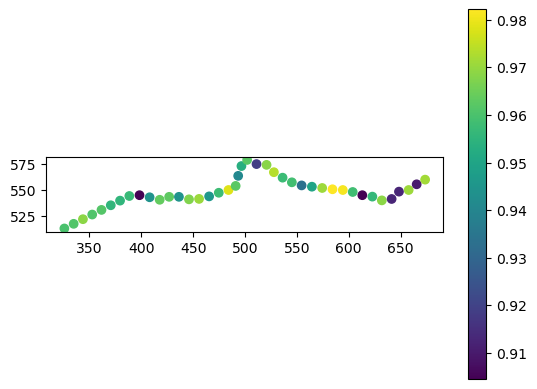

In [25]:
joined_ori.plot('depth', cmap='viridis', legend=True)

In [26]:
joined_transformed = joined_transformed.sort_values(by='distance')
joined_transformed.insert(0, 'distance2', range(0, 10 * len(joined_transformed), 10))

<AxesSubplot:>

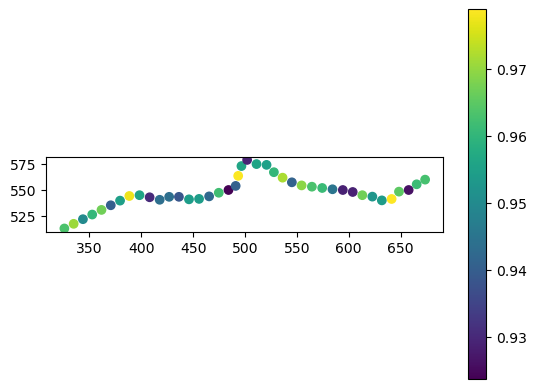

In [27]:
joined_transformed.plot('depth', cmap='viridis', legend=True)

-----------------------------------------------------------

#### River profile

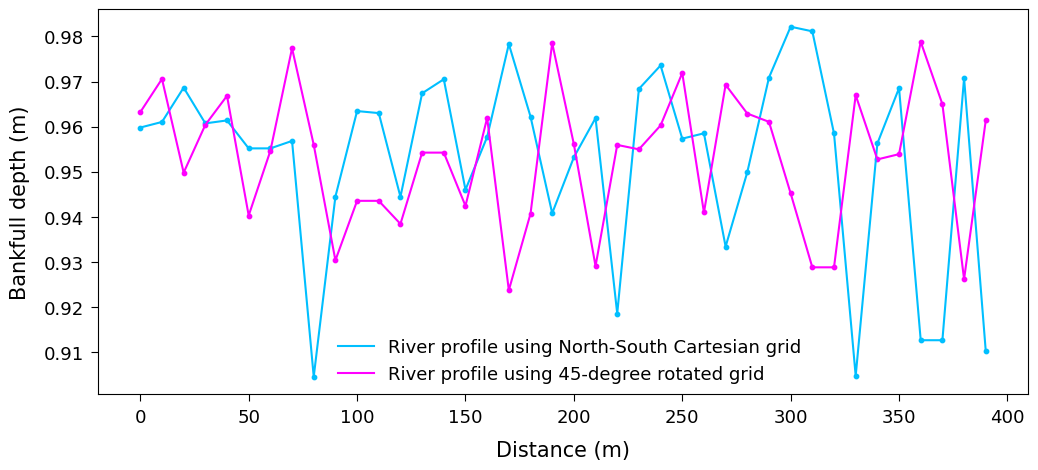

In [28]:
fig, ax = plt.subplots(figsize=(12, 5))

fontsize = 15

ax.plot(joined_ori[:-1]['distance2'], joined_ori[:-1]['depth'], color='deepskyblue', label='River profile using North-South Cartesian grid')
ax.plot(joined_transformed[:-1]['distance2'], joined_transformed[:-1]['depth'], color='fuchsia', label='River profile using 45-degree rotated grid')
ax.set_ylabel('Bankfull depth (m)', labelpad=10, fontsize=fontsize)
ax.set_xlabel('Distance (m)', labelpad=10, fontsize=fontsize)
plt.legend(frameon=False, loc=(.25, .01), fontsize=fontsize-2)

ax.scatter(joined_ori[:-1]['distance2'], joined_ori[:-1]['depth'], color='deepskyblue', s=10)
ax.scatter(joined_transformed[:-1]['distance2'], joined_transformed[:-1]['depth'], color='fuchsia', s=10)

# Design size and style for ticks and labels
for item in (ax.get_xticklabels() + ax.get_yticklabels()):  # For x, y ticks' labels
    item.set_fontsize(fontsize-2)
ax.tick_params(direction='out', length=5, pad=5)

fig.savefig(
    fr"{main_dir}\river_profiles_example.png",
    bbox_inches='tight', dpi=600
)

#### Untransformed picture

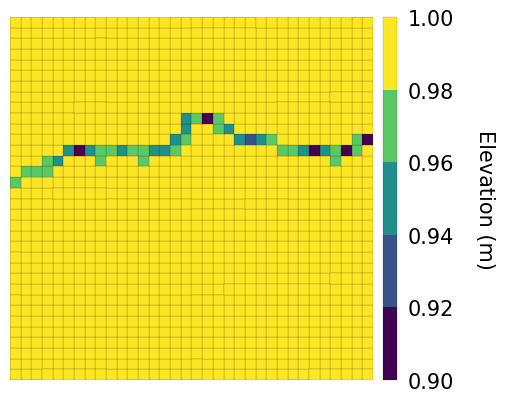

In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(5, 5))

fontsize = 15

# Set up cmap
cmap = plt.cm.viridis  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]


# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# Bound and norm
bound = np.arange(0.9, 1.01, .02)
norm = mpl.colors.BoundaryNorm(bound, cmap.N)

ori_clip_poly.plot('depth', cmap=cmap, norm=norm, legend=False, edgecolor='black', linewidth=0.1, ax=ax)

# Create a second axes for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.1)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', ticks=bound, boundaries=bound,
                               format='%.2f')

cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.1)
cb.ax.tick_params(width=0)
cb.set_label('Elevation (m)', labelpad=30, rotation=270, fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)


ax.set_xlim(left=330, right=670)
ax.set_ylim(bottom=330, top=670)

# Remove frames and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig(
    fr"{main_dir}\original_raster_example.png",
    bbox_inches='tight', dpi=600
)

#### Transformed picture

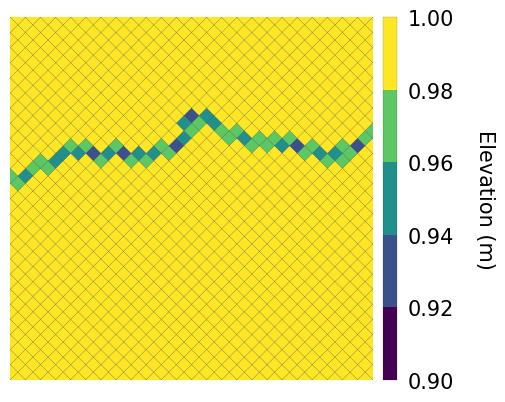

In [30]:
# Ref: https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
# https://stackoverflow.com/questions/41316914/python-decreasing-color-bar-major-ticks-size
# https://stackoverflow.com/questions/14477696/customizing-colorbar-border-color-on-matplotlib
# https://stackoverflow.com/questions/14325773/how-to-change-marker-border-width-and-hatch-width
# https://stackoverflow.com/questions/15908371/matplotlib-colorbars-and-its-text-labels
# https://linuxhint.com/matplotlib-colorbar/


# import numpy as np
# import matplotlib as mpl
# import matplotlib.pylab as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(5, 5))

fontsize = 15

# Set up cmap
cmap = plt.cm.viridis  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]


# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# Bound and norm
bound = np.arange(0.9, 1.01, .02)
norm = mpl.colors.BoundaryNorm(bound, cmap.N)

transformed_clip_poly.plot('depth', cmap=cmap, norm=norm, legend=False, edgecolor='black', linewidth=0.1, ax=ax)

# Create a second axes for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.1)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', ticks=bound, boundaries=bound,
                               format='%.2f')

cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(0.1)
cb.ax.tick_params(width=0)
cb.set_label('Elevation (m)', labelpad=30, rotation=270, fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

ax.set_xlim(left=330, right=670)
ax.set_ylim(bottom=330, top=670)

# Remove frames and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.savefig(
    fr"{main_dir}\transformed_raster_example.png",
    bbox_inches='tight', dpi=600
)